In [1]:
# docker run --gpus all -it -v $(realpath ~/):/tf/All -v /home/rob/Data2:/home/rob/Data2 --env HF_DATASETS_CACHE=/home/rob/Data2/huggingface/datasets --env TRANSFORMERS_CACHE=/home/rob/Data2/huggingface/transformers -p 8888:8888 -p 6006:6006 d139afc9cfb2

# This notebook relies on the output from previous notebooks, and reads from the folders ...
# cbow_embeddings
# glove_embeddings
# skipgram_embeddings
# elmo_embeddings


# 2nd pass ... 
# Run Date: Thursday, January 19, 2023
# Run Time: 00:00:16

# First Run ...
# Run Date: Thursday, January 19, 2023
# Run Time: 00:00:15


In [2]:
import time
from datetime import date

startTime = time.time()
todaysDate = date.today()

In [3]:
# only target the 2070 Super ...
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

## Classifying documents with embeddings

<table align="left">
    <td>
        <a target="_blank" href="https://colab.research.google.com/github/thushv89/packt_nlp_tensorflow_2/blob/master/Ch04-Advance-Word-Vectors/ch4_document_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
    </td>
</table>

In [4]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from six.moves.urllib.request import urlretrieve
import zipfile
import numpy as np
import pandas as pd
import os
import time
import random
import tensorflow as tf
from matplotlib import pylab

2023-01-19 17:15:03.560507: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 17:15:04.117935: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-19 17:15:04.117983: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-19 17:15:04.117990: W tensorfl

## Downloading the data

This code downloads a [BBC dataset](hhttp://mlg.ucd.ie/files/datasets/bbc-fulltext.zip) consisting of news articles published by BBC. 

In [5]:
url = 'http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip'


def download_data(url, data_dir):
    """Download a file if not present, and make sure it's the right size."""
    
    # Create the data directory if not exist
    os.makedirs(data_dir, exist_ok=True)

    file_path = os.path.join(data_dir, 'bbc-fulltext.zip')
    
    # If file doesnt exist, download
    if not os.path.exists(file_path):
        print('Downloading file...')
        filename, _ = urlretrieve(url, file_path)
    else:
        print("File already exists")
  
    extract_path = os.path.join(data_dir, 'bbc')
    
    # If data has not been extracted already, extract data
    if not os.path.exists(extract_path):        
        with zipfile.ZipFile(os.path.join(data_dir, 'bbc-fulltext.zip'), 'r') as zipf:
            zipf.extractall(data_dir)
    else:
        print("bbc-fulltext.zip has already been extracted")
    
download_data(url, 'data')

File already exists
bbc-fulltext.zip has already been extracted


### Read Data

Here we read all the files and keep them as a list of strings, where each string is a single article

In [6]:
def read_data(data_dir):
    
    # This will contain the full list of stories
    news_stories = []    
    filenames = []
    print("Reading files")
    
    i = 0 # Just used for printing progress
    for root, dirs, files in os.walk(data_dir):
        
        for fi, f in enumerate(files):
            
            # We don't read the readme file
            if 'readme' in f.lower():
                continue
            
            # Printing progress
            i += 1
            print("."*i, f, end='\r')
            
            # Open the file
            with open(os.path.join(root, f), encoding='latin-1') as text_file:
                
                story = []
                # Read all the lines
                for row in text_file:
                                        
                    story.append(row.strip())
                    
                # Create a single string with all the rows in the doc
                story = ' '.join(story)                        
                # Add that to the list
                news_stories.append(story)  
                filenames.append(os.path.join(root, f))
                
        print('', end='\r')
        
    print(f"\nDetected {len(news_stories)} stories")
    return news_stories, filenames
                
  
news_stories, filenames = read_data(os.path.join('data', 'bbc'))

# Printing some stats and sample data
print(f"{sum([len(story.split(' ')) for story in news_stories])} words found in the total news set")
print('Example words (start): ',news_stories[0][:50])
print('Example words (end): ',news_stories[-1][-50:])

Reading files
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

## Build a Tokenizer

Here we build a tokenizer, that performs simple preprocessing like,

* Converting letters to lower case
* Removing punctuation

and tokenize the strings based on a defined separator. Then each token is converted to an Integer ID, as computers understand numbers, not strings. In the background, the tokenizer builds a word to index dictionary, that defines a unique ID for each word in the vocabulary.

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer

n_vocab = 15000 + 1
tokenizer = Tokenizer(
    num_words=n_vocab - 1,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, split=' ', oov_token=''
)

tokenizer.fit_on_texts(news_stories)
print("Data fitted on the tokenizer")

Data fitted on the tokenizer


## Generate labels for data

We generate a label using the filenames to train a classifier

In [8]:
labels_ser = pd.Series(filenames, index=filenames).str.split(os.path.sep, expand=True).iloc[:, -2].map(
    {'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}
)
labels_ser.head()

data/bbc/tech/174.txt    4
data/bbc/tech/170.txt    4
data/bbc/tech/302.txt    4
data/bbc/tech/256.txt    4
data/bbc/tech/211.txt    4
Name: 2, dtype: int64

## Create train/test split

Here we use 67% data as training and 33% as testing data.

In [9]:
from sklearn.model_selection import train_test_split

train_labels, test_labels = train_test_split(labels_ser, test_size=0.33)

## Generating document embeddings

Here we write a function to generate document embeddings from the previous embedding arrays we saved to the disk for `skip-gram`, `CBOW` and `GloVe` algorithms.

In [10]:
def generate_document_embeddings(texts, filenames, tokenizer, embeddings):
    
    """ This function takes a sequence of tokens and compute the mean embedding vector \
    from the word vectors of all the tokens in the document """
    
    doc_embedding_df = [] # Contains document embeddings for all the articles
    assert isinstance(embeddings, pd.DataFrame), 'embeddings must be a pd.DataFrame'
    
    # This is a trick we use to quickly get the text preprocessed by the tokenizer
    # We first convert text to a sequences, and then back to text, which will give the
    # preprocessed tokens
    sequences = tokenizer.texts_to_sequences(texts)    
    preprocessed_texts = tokenizer.sequences_to_texts(sequences)
    
    # For each text,
    for text in preprocessed_texts:
        # Make sure we had matches for tokens in the embedding matrx
        assert embeddings.loc[text.split(' '), :].shape[0]>0
        # Compute mean of all the embeddings associated with words
        mean_embedding = embeddings.loc[text.split(' '), :].mean(axis=0)
        # Add that to list
        doc_embedding_df.append(mean_embedding)
        
    # Save the doc embeddings in a dataframe
    doc_embedding_df = pd.DataFrame(doc_embedding_df, index=filenames)
    
    return doc_embedding_df


## Compute skip-gram based document embeddings

In [11]:
# Load the skip-gram embeddings context and target
# skipgram_context_embeddings = pd.read_pickle(
#     os.path.join('../Ch03-Word-Vectors/skipgram_embeddings', 'context_embedding.pkl')
# )
# skipgram_target_embeddings = pd.read_pickle(
#     os.path.join('../Ch03-Word-Vectors/skipgram_embeddings', 'target_embedding.pkl')
# )

skipgram_context_embeddings = pd.read_pickle(
    os.path.join('skipgram_embeddings', 'context_embedding.pkl')
)

skipgram_target_embeddings = pd.read_pickle(
    os.path.join('skipgram_embeddings', 'target_embedding.pkl')
)

skipgram_context_embeddings.head(n=10)

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
None,-1.316333,-1.221975,-0.467647,-1.396968,-1.432016,-1.207448,-1.101838,1.052194,1.072836,-1.528851,...,-1.390015,1.239915,1.274788,1.049227,-1.104107,-1.243190,0.939885,-1.421062,-1.499624,-1.080712
,-0.412803,-0.035928,0.288849,-0.363882,-0.305106,0.205149,0.091930,-0.010472,0.132615,-0.408150,...,-0.284370,0.087606,0.137417,0.043261,-0.481205,0.123714,-0.569555,-0.451168,-0.352354,0.011649
the,-0.194968,0.093303,-0.584173,-0.078631,-0.209103,0.010848,-0.154229,1.031888,-0.229217,-0.293748,...,-0.222775,-0.015692,0.392113,-0.095261,-0.051168,0.047403,0.038055,0.001454,-0.400580,-0.290883
to,-0.198526,0.067451,0.037129,-0.291451,0.053430,-0.104727,-1.284974,0.083238,-0.267700,-0.368171,...,-0.285382,0.328785,0.095541,0.476249,-0.276102,-0.795023,0.751375,0.004050,-0.303178,-0.524545
of,-0.061144,0.084153,0.282463,-0.143367,-0.134334,0.124301,0.430935,0.746847,0.072491,-0.579628,...,-0.085016,0.241277,0.676889,-0.034564,0.348457,0.110958,-0.257479,-0.422164,-0.433074,0.312345
and,0.136064,0.355507,-0.243120,-0.226366,0.026080,-0.298392,0.006160,0.017019,0.237877,-0.020025,...,0.483521,0.098399,-0.043496,0.092716,0.289546,-0.022778,1.049736,-0.596496,-0.303149,-0.107286
a,-0.254484,-0.583910,0.301826,-0.451182,-0.930586,0.086182,-0.615651,0.098293,0.176085,-0.278348,...,-0.150994,0.718540,0.903492,1.238822,0.194144,0.054024,-0.490397,-0.032465,-0.532481,-1.017847
in,-0.337662,0.117969,1.056176,0.011870,-0.115448,-0.861911,0.230234,0.011239,-0.439489,-0.371944,...,0.015385,0.136871,0.095159,0.537449,0.073490,-0.052828,-0.356154,-0.051445,-0.732453,-0.009737
for,-0.429915,-0.036498,-0.119357,-0.642725,-0.677542,-0.408580,-0.503838,-0.601547,0.102813,-0.135099,...,-0.264239,0.607912,-0.214494,0.478466,-0.792367,0.190519,0.485500,0.049492,-0.454006,0.296545
is,-0.673565,-0.409569,1.147624,-0.356622,-0.198234,-0.526193,-1.086224,-0.534911,1.155104,-0.981866,...,-1.055679,-0.028795,-0.278553,-0.205192,-0.057671,-0.376930,-0.744690,-0.250684,0.171369,0.618726


In [12]:
# Compute the mean of context & target embeddings for better embeddings
skipgram_embeddings = (skipgram_context_embeddings + skipgram_target_embeddings)/2
# Generate the document embeddings with the average context target embeddings
skipgram_doc_embeddings = generate_document_embeddings(news_stories, filenames, tokenizer, skipgram_embeddings)

## Train a document classifier

Here we train a simple document classifier, using document embeddings as inputs and labels we generated as targets. To get a consistent measure, we will run several trials.

---
*Document classifier*

![Document classifier](notebook_images/04_06.png)

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def get_classification_accuracy(doc_embeddings, train_labels, test_labels, n_trials):
    """ Train a simple MLP model for several trials and measure test accuracy"""
    
    accuracies = [] # Store accuracies across trials
    
    print(doc_embeddings.loc[train_labels.index])
    print(train_labels.astype('int'))
    # For each trial
    for trial in range(n_trials):
        # Create a MLP classifier
        lr_classifier = LogisticRegression(multi_class='multinomial', max_iter=500)
        
        # Fit the model on training data
        lr_classifier.fit(doc_embeddings.loc[train_labels.index], train_labels)
        
        # Get the predictions for test data
        predictions = lr_classifier.predict(doc_embeddings.loc[test_labels.index])
    
        # Compute accuracy
        accuracies.append(accuracy_score(predictions, test_labels))
    
    return accuracies

# Get classification accuracy for skip-gram models
skipgram_accuracies = get_classification_accuracy(
    skipgram_doc_embeddings, train_labels.astype('int'), test_labels.astype('int'), n_trials=5
)

print(f"Skip-gram accuracies: {skipgram_accuracies}")

                                     0         1         2         3    \
data/bbc/business/313.txt      -0.074537 -0.022835 -0.049338 -0.067668   
data/bbc/entertainment/045.txt -0.082740 -0.084647  0.008997 -0.080020   
data/bbc/entertainment/197.txt -0.068181 -0.053321 -0.016951 -0.080832   
data/bbc/sport/100.txt         -0.060590 -0.045593 -0.021484 -0.075009   
data/bbc/sport/378.txt         -0.059777 -0.085243  0.024250 -0.088373   
...                                  ...       ...       ...       ...   
data/bbc/sport/055.txt         -0.082552 -0.047622 -0.017358 -0.071503   
data/bbc/entertainment/001.txt -0.082694 -0.049631 -0.035745 -0.082065   
data/bbc/tech/369.txt          -0.081587 -0.042815 -0.004183 -0.091311   
data/bbc/entertainment/269.txt -0.060973 -0.060244 -0.019892 -0.076199   
data/bbc/sport/431.txt         -0.067782 -0.043888 -0.010045 -0.075900   

                                     4         5         6         7    \
data/bbc/business/313.txt      -0.056

## Train a classifier on CBOW based document embeddings

In [14]:
# cbow_context_embeddings = pd.read_pickle(
#     os.path.join('../Ch03-Word-Vectors/cbow_embeddings', 'context_embedding.pkl')
# )
# cbow_target_embeddings = pd.read_pickle(
#     os.path.join('../Ch03-Word-Vectors/cbow_embeddings', 'target_embedding.pkl')
# )


cbow_context_embeddings = pd.read_pickle(
    os.path.join('cbow_embeddings', 'context_embedding.pkl')
)

cbow_target_embeddings = pd.read_pickle(
    os.path.join('cbow_embeddings', 'target_embedding.pkl')
)


cbow_embeddings = (cbow_context_embeddings + cbow_target_embeddings)/2
cbow_doc_embeddings = generate_document_embeddings(news_stories, filenames, tokenizer, cbow_embeddings)

In [15]:
cbow_accuracies = get_classification_accuracy(
    cbow_doc_embeddings, train_labels, test_labels, n_trials=5
)
print(cbow_accuracies)

                                     0         1         2         3    \
data/bbc/business/313.txt      -0.080031  0.124552 -0.090819 -0.068457   
data/bbc/entertainment/045.txt -0.041774  0.058377 -0.056427 -0.046418   
data/bbc/entertainment/197.txt -0.071520  0.088465 -0.080754 -0.088848   
data/bbc/sport/100.txt         -0.087848  0.098416 -0.091055 -0.080063   
data/bbc/sport/378.txt         -0.073222  0.037675 -0.034639 -0.054382   
...                                  ...       ...       ...       ...   
data/bbc/sport/055.txt         -0.068862  0.067742 -0.108815 -0.074146   
data/bbc/entertainment/001.txt -0.077338  0.104004 -0.109309 -0.068990   
data/bbc/tech/369.txt          -0.067491  0.078481 -0.062365 -0.093093   
data/bbc/entertainment/269.txt -0.087191  0.097004 -0.117959 -0.094483   
data/bbc/sport/431.txt         -0.070375  0.060200 -0.071131 -0.095909   

                                     4         5         6         7    \
data/bbc/business/313.txt      -0.050

## Train a classifier on GloVe embeddings

In [16]:
# glove_context_embeddings = pd.read_pickle(
#     os.path.join('glove_embeddings', 'context_embedding_and_bias.pkl')
# )
# glove_target_embeddings = pd.read_pickle(
#     os.path.join('glove_embeddings', 'target_embedding_and_bias.pkl')
# )

glove_context_embeddings = pd.read_pickle(
    os.path.join('glove_embeddings', 'context_embedding_and_bias.pkl')
)

glove_target_embeddings = pd.read_pickle(
    os.path.join('glove_embeddings', 'target_embedding_and_bias.pkl')
)

glove_embeddings = (glove_context_embeddings.iloc[:, :-1] + glove_target_embeddings.iloc[:, :-1])/2
glove_doc_embeddings = generate_document_embeddings(news_stories, filenames, tokenizer, glove_embeddings)

In [17]:
glove_accuracies = get_classification_accuracy(
    glove_doc_embeddings, train_labels, test_labels, n_trials=5
)
print(glove_accuracies)

                                     0         1         2         3    \
data/bbc/business/313.txt       0.106106  0.216254 -0.036073  0.068143   
data/bbc/entertainment/045.txt  0.125770  0.180885  0.015304  0.077578   
data/bbc/entertainment/197.txt  0.114940  0.205332 -0.032697  0.061498   
data/bbc/sport/100.txt          0.114397  0.205747 -0.053286  0.052973   
data/bbc/sport/378.txt          0.105602  0.178900 -0.012490  0.044315   
...                                  ...       ...       ...       ...   
data/bbc/sport/055.txt          0.111029  0.195338 -0.059469  0.051265   
data/bbc/entertainment/001.txt  0.127385  0.218446 -0.019569  0.070928   
data/bbc/tech/369.txt           0.108568  0.188743 -0.038029  0.059675   
data/bbc/entertainment/269.txt  0.136771  0.216713 -0.031295  0.068399   
data/bbc/sport/431.txt          0.096833  0.201042 -0.024751  0.058077   

                                     4         5         6         7    \
data/bbc/business/313.txt       0.083

## Train a classifier on ELMo document embeddings

In [18]:
elmo_doc_embeddings = pd.read_pickle(
    os.path.join('elmo_embeddings', 'elmo_embeddings.pkl')
)

elmo_doc_embeddings.head(n=10)

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
data/bbc/tech/174.txt,0.012744,0.023062,-0.035946,-0.090556,0.144047,0.166769,0.017964,0.342860,-0.161670,-0.082526,...,-0.340656,0.244855,0.030709,0.253689,0.078406,0.044581,0.372656,-0.006501,0.273694,0.057726
data/bbc/tech/170.txt,0.256800,-0.076643,-0.005060,-0.063172,0.138440,0.189914,0.182261,0.326142,-0.117797,0.026969,...,-0.171903,0.165076,-0.113165,0.327153,0.209255,0.082908,0.258461,-0.122383,0.307110,-0.029122
data/bbc/tech/302.txt,0.178142,0.275478,-0.044081,0.069659,0.219834,0.160469,-0.008855,0.358277,0.126847,-0.048421,...,-0.290554,0.097650,-0.033120,0.317354,-0.011647,0.147325,0.441159,-0.065567,0.119717,-0.027908
data/bbc/tech/256.txt,0.113356,-0.150963,-0.054547,0.078308,0.010922,0.414599,-0.085480,0.392278,0.147020,-0.126910,...,-0.291242,0.131670,0.126649,0.161829,0.085308,0.041790,0.132907,-0.010835,0.489633,-0.170547
data/bbc/tech/211.txt,0.161718,0.072896,-0.033089,-0.112782,0.426878,0.299916,0.084742,0.284771,-0.164555,0.051139,...,-0.091179,0.205737,-0.067422,0.088594,0.118239,0.079229,0.402150,-0.011402,0.355481,-0.067534
data/bbc/tech/326.txt,0.312790,0.138870,-0.076327,-0.154205,0.167426,0.080995,-0.002776,0.164310,-0.102516,-0.095217,...,-0.307079,0.203746,0.135431,0.132567,-0.003398,0.045161,0.251887,-0.018399,0.091552,-0.091546
data/bbc/tech/363.txt,0.051522,-0.116508,0.021444,-0.132232,0.174894,0.095304,0.127901,0.435579,0.012038,-0.146804,...,-0.151405,0.153150,0.066877,0.345065,-0.029675,-0.109978,0.193816,-0.107168,0.357005,0.030061
data/bbc/tech/134.txt,0.065984,0.055749,0.033957,-0.087867,0.198809,0.185405,0.116618,0.416797,-0.158576,-0.039389,...,-0.207431,0.237969,0.020248,0.474798,0.147314,-0.086313,0.283539,-0.038299,0.322855,-0.083530
data/bbc/tech/050.txt,0.077217,0.065682,0.045798,-0.091198,0.452054,0.358033,0.088634,0.393721,-0.214198,0.206301,...,-0.242007,0.274968,-0.058163,0.344481,0.183206,0.059261,0.382113,-0.144127,0.195141,-0.019669
data/bbc/tech/001.txt,-0.035935,-0.057713,-0.042617,-0.214429,-0.067015,0.157125,0.029188,0.084584,-0.334528,-0.030607,...,-0.208489,0.161351,0.008093,0.035859,0.009524,0.140167,0.169122,0.021745,0.425750,0.016636


In [19]:
elmo_accuracies = get_classification_accuracy(
    elmo_doc_embeddings, train_labels, test_labels, n_trials=5
)
print(elmo_accuracies)

                                    0         1         2         3     \
data/bbc/business/313.txt      -0.221736  0.105317  0.081787 -0.274011   
data/bbc/entertainment/045.txt -0.323768 -0.031293  0.156228 -0.069630   
data/bbc/entertainment/197.txt  0.217634 -0.178705 -0.027458 -0.012849   
data/bbc/sport/100.txt         -0.279527 -0.380739 -0.022975 -0.207223   
data/bbc/sport/378.txt          0.023839 -0.220556  0.071147  0.039579   
...                                  ...       ...       ...       ...   
data/bbc/sport/055.txt         -0.157657 -0.122415 -0.136604 -0.054244   
data/bbc/entertainment/001.txt -0.033875 -0.151102 -0.111134 -0.189952   
data/bbc/tech/369.txt          -0.012196  0.043267 -0.087469  0.017215   
data/bbc/entertainment/269.txt -0.186900 -0.080020  0.115196 -0.046049   
data/bbc/sport/431.txt         -0.065461 -0.211498  0.017491 -0.044656   

                                    4         5         6         7     \
data/bbc/business/313.txt      -0.066

## Plot the accuracies of different models

Here we plot the accuracies from 5 trials, for different algorithms as box plots.

In [20]:
accuracy_df = pd.DataFrame(
    np.array([skipgram_accuracies, cbow_accuracies, glove_accuracies, elmo_accuracies]).T,
    columns = ['Skipgram', 'CBOW', "GloVe", "ELMo"]
)

accuracy_df.head()

,Skipgram,CBOW,GloVe,ELMo
0,0.880272,0.842177,0.697959,0.978231
1,0.880272,0.842177,0.697959,0.978231
2,0.880272,0.842177,0.697959,0.978231
3,0.880272,0.842177,0.697959,0.978231
4,0.880272,0.842177,0.697959,0.978231


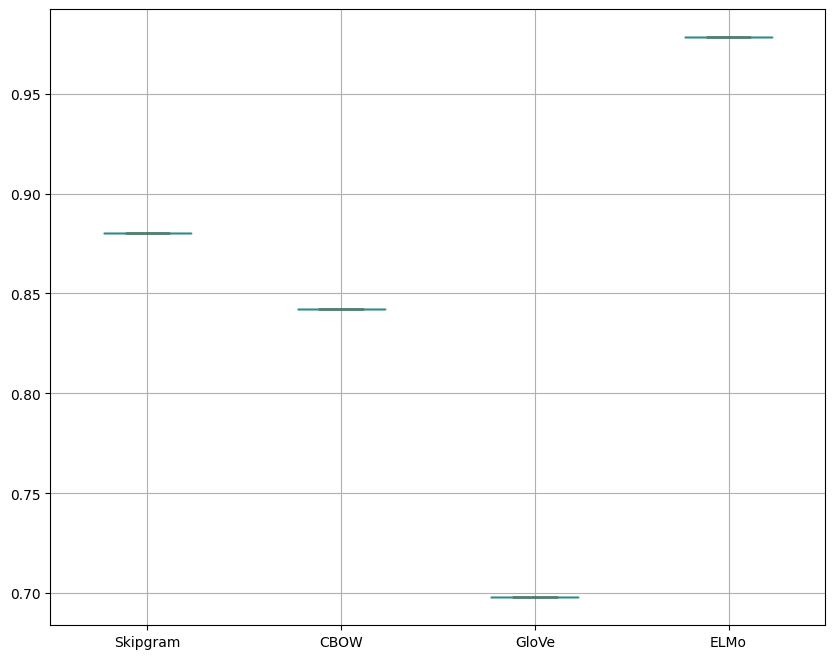

In [21]:
boxplot = accuracy_df.boxplot(figsize=(10,8))

In [22]:
endTime = time.time()
elapsedTime = time.strftime("%H:%M:%S", time.gmtime(endTime - startTime))

print(todaysDate.strftime('# Run Date: %A, %B %d, %Y'))
print(f"# Run Time: {elapsedTime}")

# Run Date: Thursday, January 19, 2023
# Run Time: 00:00:16
